# Transfer learning with Tensorflow part 1: feature extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems

There are 2 main benefits: 
1. Can leverage an existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working neural network which has already learned patterns on similar data to our own, then we can adapt those patterns to our own, then we can adapt those patterns to our own data 

In [ ]:
# Are we using GPU
!nvidia-smi

Sun Jun 12 02:54:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data



In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-06-12 02:54:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.250.159.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   175MB/s    in 0.9s    

2022-06-12 02:54:16 (175 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of file
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print (f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [ ]:
# Set up data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the Tensorboard callback
* Model checkpoint with the Model Checkpoint callback
* Stopping a model from training (before it trains too long and overfits with the early stopping callback 

In [ ]:
# Create Tensorboard callback (functionized because we need to create a new one for each)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using Tensorflow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch

Now we're going to do a similar, except the majority of our model's layers are going to come from Tensorflow Hub.

We can access pretrained models on : https://tfhub.dev/

Browsing through the tensorflow hub page and sorting for image classification, we found the following feature vector model link : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following 2 models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
tf.__version__

'2.8.2'

In [ ]:
# Let's make a create model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub Url and creates a Keras Sequential model with it.

  Args:
    model_url(str): A tensorflow feature extraction URL
    num_classes(int): Number of output neurons in the output layer, should be equal to number of target classes, default 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # Freeze the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing a ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
callback = create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")
# Let's fit our resNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[callback]) # name of log files

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20220612-025433
Epoch 1/5
24/24 [==============================] - 32s 752ms/step - loss: 1.8675 - accuracy: 0.3547 - val_loss: 1.1688 - val_accuracy: 0.6176
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.8799 - accuracy: 0.7280 - val_loss: 0.8568 - val_accuracy: 0.7184
Epoch 3/5
24/24 [==============================] - 16s 679ms/step - loss: 0.6016 - accuracy: 0.8387 - val_loss: 0.7521 - val_accuracy: 0.7556
Epoch 4/5
24/24 [==============================] - 16s 675ms/step - loss: 0.4668 - accuracy: 0.8867 - val_loss: 0.7086 - val_accuracy: 0.7628
Epoch 5/5
24/24 [==============================] - 16s 684ms/step - loss: 0.3723 - accuracy: 0.9227 - val_loss: 0.6711 - val_accuracy: 0.7788


Our transfer learning model feature extractor model out performed all of the previous models we build by hand (substancially) and in a quicker training time

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called helper.py and plot it

import matplotlib.pyplot as plt


# Plot the validation and training curves seperately
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args: 
    History : Tensorflow History object

  Returns:  
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) #how many epochs did we run for

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

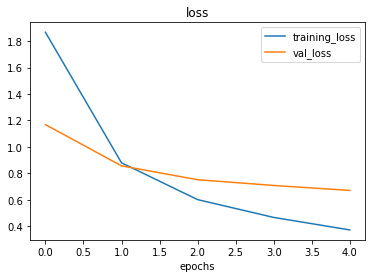

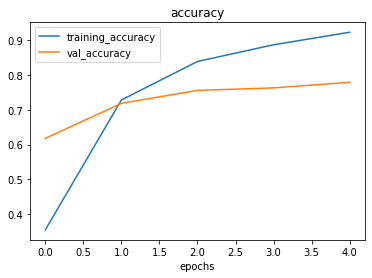

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub feature extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet Model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet Model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                                     experiment_name="efficientnetb0")])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20220612-025628
Epoch 1/5
24/24 [==============================] - 26s 725ms/step - loss: 1.8698 - accuracy: 0.3893 - val_loss: 1.3285 - val_accuracy: 0.7148
Epoch 2/5
24/24 [==============================] - 16s 686ms/step - loss: 1.0937 - accuracy: 0.7413 - val_loss: 0.8870 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 16s 691ms/step - loss: 0.7760 - accuracy: 0.8440 - val_loss: 0.7084 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 21s 898ms/step - loss: 0.6172 - accuracy: 0.8680 - val_loss: 0.6224 - val_accuracy: 0.8508
Epoch 5/5
24/24 [==============================] - 17s 718ms/step - loss: 0.5192 - accuracy: 0.8853 - val_loss: 0.5641 - val_accuracy: 0.8652


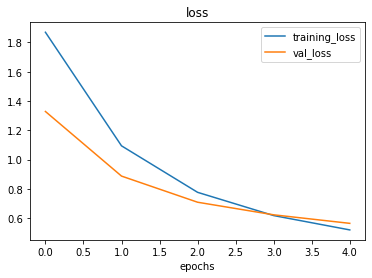

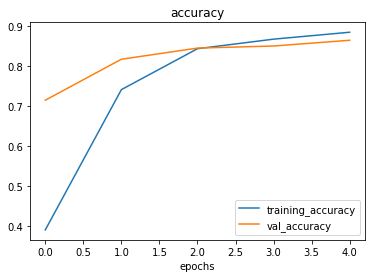

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (EfficientNetB0 trained on ImageNet) and adjust the output layer for your problem (e.g 1000 classes -> 10 classes of food)
* **"Fine tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [ ]:
# How many layers does out efficientnetb0 feature extractor model have?
len(efficientnet_model.layers[0].weights)

309

## Comparing our models using tensorBoard

> **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) don't upload them to TensorBoard.dev

In [ ]:
# Upload tensorBoard dev records 
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing 2 different TF hub Feature extraction model architectures using 10% of the training data" \
  --one_shot



***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=BCzVgQwLcLwRaT2VvaQjUfr0gYKvbm&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/ARcrzL34QdynGQDXnq2dGQ/


In [ ]:
# Check out the tensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/ARcrzL34QdynGQDXnq2dGQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing 2 different TF hub Feature extraction model architectures using 10% of the training data
	Id                   ARcrzL34QdynGQDXnq2dGQ
	Created              2022-06-12 03:39:35 (3 minutes ago)
	Updated              2022-06-12 03:39:37 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794963
Total: 1 experiment(s)
